In [217]:
# set up libraries + backend
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.pulse import pulse_lib
from qiskit.pulse import Play
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
from scipy.interpolate import splrep, sproot, splev

%config InlineBackend.figure_format = 'svg' # cleans up backend

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# conversion factors
GHz = 1.0e9 
MHz = 1.0e6
kHz = 1.0e3
ms = 1.0e-3
us = 1.0e-6
ns = 1.0e-9 
scale_factor = 1e-14 

# Initialize qubit to |0> and retrieve backend frequencies
qubit = 0 # ground state qubit
dt = backend_config.dt # backend time-step
backend_defaults = backend.defaults()
qubit_props_dict = backend.properties().qubit_property(0)
rough_cavity_freq = backend_defaults.meas_freq_est[qubit]

# assign measurement map
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
qubit_meas_group = backend_config.meas_map[meas_map_idx]
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit_meas_group)

# assign experiment channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# define for convenience
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

ibmqfactory.load_account:WARNING:2020-07-21 14:38:11,374: Credentials are already in use. The existing account in the session will be replaced.


In [218]:
# Define measurement, acquisition parameters
meas_amp = 0.0
acq_samp_us = 0.05
meas_sigma_us = 0.01
meas_risefall_us = 0.01

acq_samp = get_closest_multiple_of_16(acq_samp_us * us/dt)
meas_sigma = get_closest_multiple_of_16(meas_sigma_us * us/dt)
meas_risefall = get_closest_multiple_of_16(meas_risefall_us * us/dt)
meas_pulse = pulse_lib.gaussian_square(duration=acq_samp, amp=meas_amp, sigma=meas_sigma, risefall=meas_risefall)

# Make measurement schedule
meas_schedule = pulse.Schedule(name="Measurement")
meas_schedule += Play(meas_pulse, meas_chan)
meas_schedule += pulse.Acquire(duration=acq_samp, 
                               channel=[pulse.AcquireChannel(i) for i in qubit_meas_group],
                               mem_slot=[pulse.MemorySlot(i) for i in qubit_meas_group])
acq_pulse = pulse.Acquire(duration=acq_samp, 
                               channel=[pulse.AcquireChannel(i) for i in qubit_meas_group],
                               mem_slot=[pulse.MemorySlot(i) for i in qubit_meas_group])

# Design cavity pulse
cav_dur_us = 3.0 # This can be varied
cav_amp = 1.0 # Max possible amp
cav_dur = get_closest_multiple_of_16(cav_dur_us * us/dt)
cavity_pulse = pulse_lib.gaussian_square(duration=cav_dur, amp=cav_amp, 
                                    sigma=meas_sigma, risefall=meas_risefall)

In [219]:
# Define data fit function
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

# Define function to retrieve job results from backend as data list
def job_data(job):
    # extract + normalize results
    job_results = job.result(timeout=120)
    values = []
    for i in range(len(job_results.results)):
        res = job_results.get_memory(i)*scale_factor
        value = np.real(res[qubit]*np.conjugate(res[qubit]))
        values.append(value)
    return values

In [220]:
# Define protocol to drive cavity + then measure decay throughout a given time interval
def get_kappa(time_max_us):
    # Linewidth experiment parameters
    num_times=50 # number of sampled times during decay
    times_us = np.linspace(0, time_max_us, num_times, endpoint=True)
    delay_times_dt = times_us * us / dt
    kappa_schedules = [] # full list of acquisitions for driven cavity at each time in delay_times_dt
    for delay in delay_times_dt:
        this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
        this_schedule += Play(cavity_pulse, meas_chan) # Drive cavity with fixed cav pulse
        this_schedule += meas_schedule << int(delay) # Delay each acquisition by this 'delay' 
        kappa_schedules.append(this_schedule) 
    
    # assemble schedules
    num_shots = 256
    kappa_experiment = assemble(kappa_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{meas_chan: rough_cavity_freq}] * len(kappa_schedules))

    kappa_job = backend.run(kappa_experiment)
    print(kappa_job.job_id())
    job_monitor(kappa_job)
    
    kappa_data = job_data(kappa_job)
    
    # Fit the data
    kappa_fit_params, kappa_y_fit = fit_function(times_us, kappa_data, 
            lambda x, A, C, k: (A * np.exp(-k*x) + C),
            [3.5, -2, 0.3]
            )
    
    # Plot each decay with exponential fit
    plt.scatter(times_us, kappa_data, color='black')
    plt.plot(times_us, kappa_y_fit, color='red')
    plt.xlim([min(times_us), max(times_us)])
    plt.xlabel("Delay time [us]")
    plt.ylabel("Measured signal [au]")
    plt.show()

    # Extract decay rate
    _, _, kappa_MHz = kappa_fit_params
    print(f"Kappa found is {kappa_MHz} MHz")
    
    kappa_Hz = kappa_MHz * MHz
    return kappa_Hz

5f1736246ab212001867f971
Job Status: job has successfully run


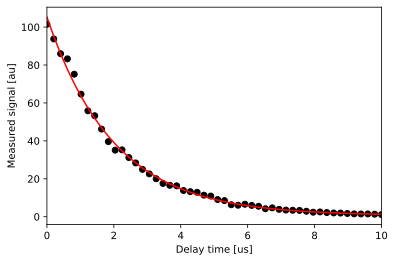

Kappa found is 0.4996801659011884 MHz


499680.1659011884

In [221]:
# Sample trial
get_kappa(10)

5f1613569def8b001b4380fc
Job Status: job has successfully run


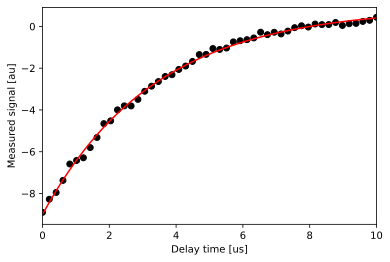

Kappa found is 0.2982717091084181 MHz
5f1613ba21f594001bf26eb4
Job Status: job has successfully run


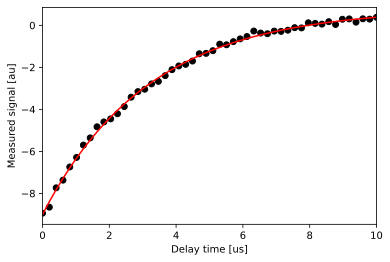

Kappa found is 0.31358857333629264 MHz
5f1613ee9def8b001b438106
Job Status: job has successfully run


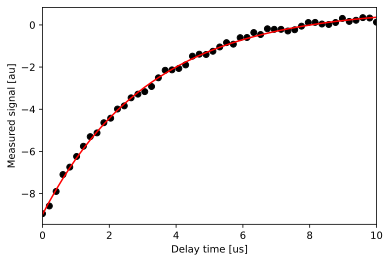

Kappa found is 0.3141238002400831 MHz
5f161424cd6a2b0019f267bc
Job Status: job has successfully run


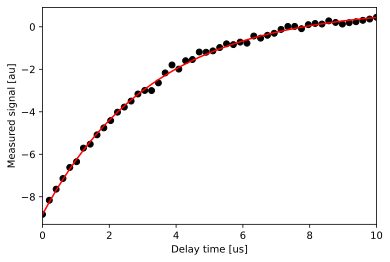

Kappa found is 0.30397078930860805 MHz
5f161458cd6a2b0019f267c0
Job Status: job has successfully run


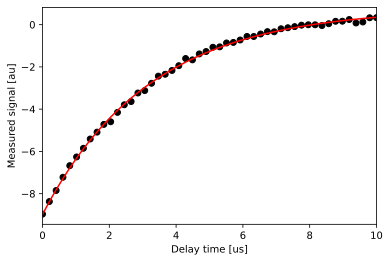

Kappa found is 0.3133047920812399 MHz
5f16148cfc7baf001a117d1b
Job Status: job has successfully run


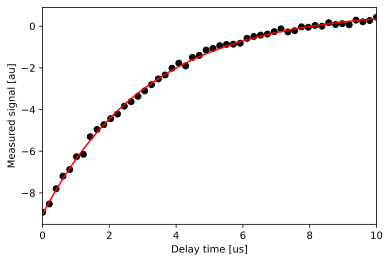

Kappa found is 0.31467304488068765 MHz
5f1614c221f594001bf26ec4
Job Status: job has successfully run


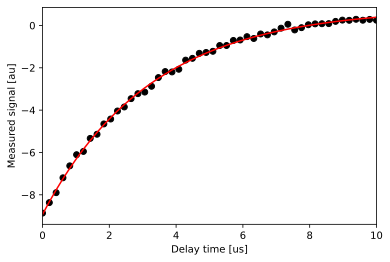

Kappa found is 0.3103324876275643 MHz
5f1614f5128c58001979da41
Job Status: job has successfully run


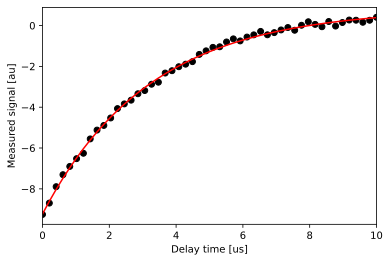

Kappa found is 0.31251324796936497 MHz
5f16152b30d0e8001a4e5386
Job Status: job has successfully run


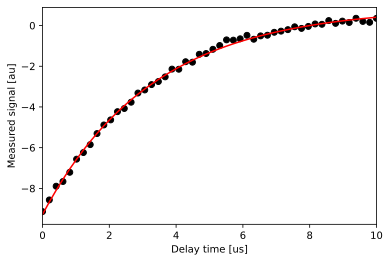

Kappa found is 0.30424052464858975 MHz
5f16155fe5ddf1001a1c1e1d
Job Status: job has successfully run


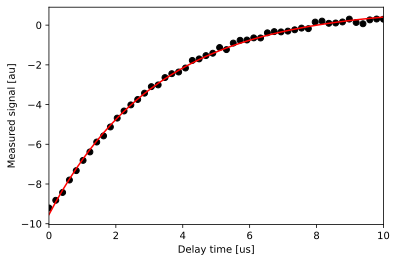

Kappa found is 0.3077124334506199 MHz
5f16159347812e001ae6aacd
Job Status: job has successfully run


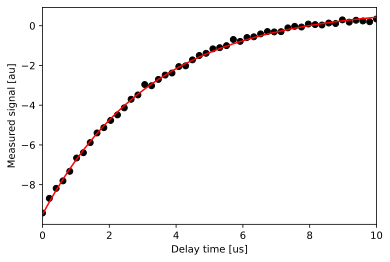

Kappa found is 0.3044300969177306 MHz
5f16165530d0e8001a4e539a
Job Status: job has successfully run


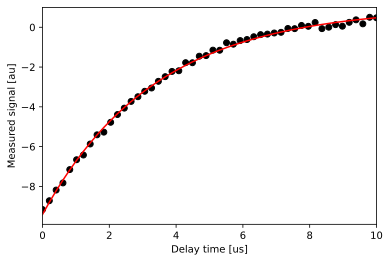

Kappa found is 0.2962658483890259 MHz
5f161719128c58001979da63
Job Status: job has successfully run


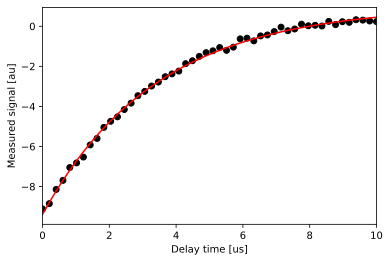

Kappa found is 0.2925360262272747 MHz
5f1617df21f594001bf26ef0
Job Status: job has successfully run


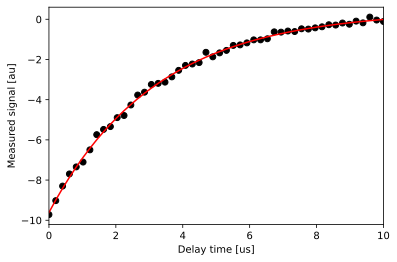

Kappa found is 0.3126525198639276 MHz
5f161813e5ddf1001a1c1e4b
Job Status: job has successfully run


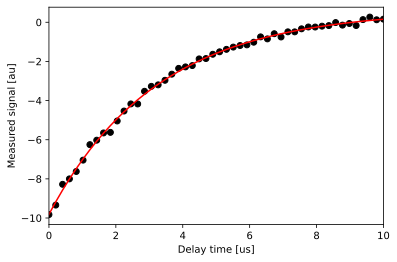

Kappa found is 0.310244240931791 MHz
5f161847e5ddf1001a1c1e50
Job Status: job has successfully run


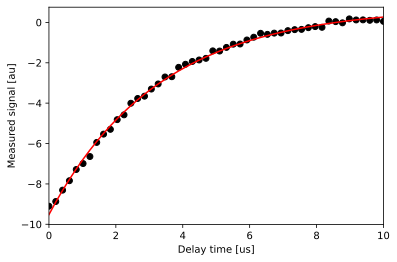

Kappa found is 0.3042475732930988 MHz
5f16187dcd6a2b0019f26811
Job Status: job has successfully run


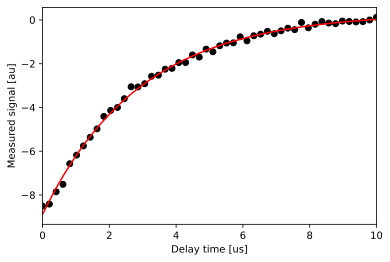

Kappa found is 0.34298561189720167 MHz
5f1618b1a8664f001939e93d
Job Status: job has successfully run


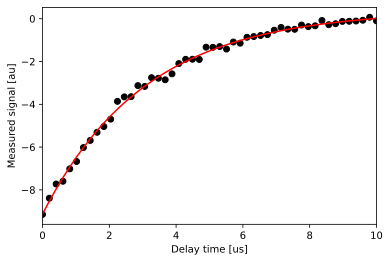

Kappa found is 0.3229686472369939 MHz
5f1618e547812e001ae6ab02
Job Status: job has successfully run


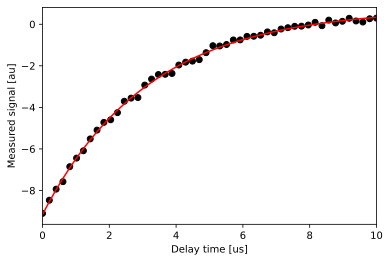

Kappa found is 0.3144020286916779 MHz
5f1619189def8b001b43815a
Job Status: job has successfully run


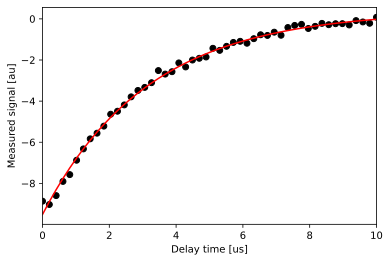

Kappa found is 0.31767097763683627 MHz


In [214]:
# Run 20 trials, get statistics
kappas_10 = []
num_trials = 20
for i in range(num_trials):
    kappa = get_kappa(10)
    kappas_10.append(kappa)

In [215]:
# View sample kappas to confirm relative uniformity (no issues with fit)
kappas_10

[298271.7091084181,
 313588.57333629264,
 314123.8002400831,
 303970.78930860804,
 313304.7920812399,
 314673.04488068767,
 310332.48762756435,
 312513.247969365,
 304240.5246485897,
 307712.43345061986,
 304430.0969177306,
 296265.8483890259,
 292536.0262272747,
 312652.5198639276,
 310244.24093179096,
 304247.57329309883,
 342985.6118972017,
 322968.64723699394,
 314402.0286916779,
 317670.9776368363]

In [216]:
# Show statistics
kappa_mean = np.mean(kappas_10)
kappa_stdev = np.std(kappas_10)
print(f"Mean linewidth is {kappa_mean / MHz} MHz and standard deviation is {kappa_stdev / kHz} kHz")

Mean linewidth is 0.31055674868685135 MHz and standard deviation is 10.427041959035643 kHz


In [ ]:
# IGNORE CELLS BELOW, USED FOR TESTING THOSE ABOVE

In [197]:
# Linewidth experiment parameters
time_max_us = 10
time_step_us = 0.25
times_us = np.arange(0, time_max_us, time_step_us) # array of time delays between excitation and measurement
delay_times_dt = times_us * us / dt
kappa_schedules = [] # separate schedule for each delay time
for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
    this_schedule += Play(cavity_pulse, meas_chan)
    this_schedule += meas_schedule << int(delay)
    kappa_schedules.append(this_schedule)

In [198]:
# assemble schedules
num_shots = 256
kappa_experiment = assemble(kappa_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{meas_chan: rough_cavity_freq}] * len(kappa_schedules))

kappa_job = backend.run(kappa_experiment)
print(kappa_job.job_id())
job_monitor(kappa_job)

5f160c3c30d0e8001a4e52f8
Job Status: job has successfully run


In [203]:
# extract + normalize results
kappa_results = kappa_job.result(timeout=120)
kappa_values = []
for i in range(len(times_us)):
    kappa_values.append(kappa_results.get_memory(i)[qubit]*scale_factor)
kappa_values = np.real(kappa_values)

In [204]:
# Define data fit function
from scipy.optimize import curve_fit
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [205]:
# Fit the data
kappa_fit_params, kappa_y_fit = fit_function(times_us, kappa_values, 
            lambda x, A, C, k: (A * np.exp(-k*x) + C),
            [3.5, -2, 0.3]
            )

_, _, kappa_MHz = kappa_fit_params

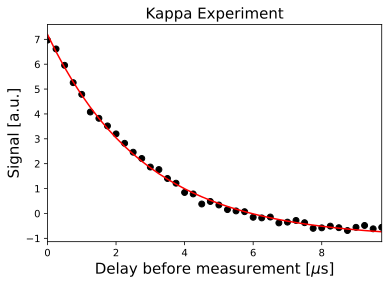

In [206]:
# Plot the data
plt.scatter(times_us, kappa_values, color='black')
plt.plot(times_us, kappa_y_fit, color='red')
plt.xlim(0, np.max(times_us))
plt.title("Kappa Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

In [207]:
print(f"Kappa is {kappa_MHz} MHz")

Kappa is 0.35394894652801046 MHz


5f173cc96ab212001867f9c3
Job Status: job has successfully run


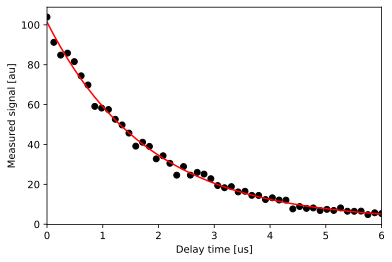

Kappa found is 0.5527698732876384 MHz
5f173e5c5d734c0013eb1fe0
Job Status: job has successfully run


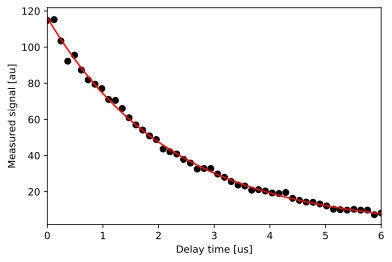

Kappa found is 0.44833284318663186 MHz
5f173ff85d734c0013eb1fee
Job Status: job has successfully run


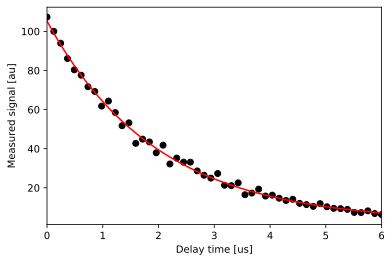

Kappa found is 0.510886001662088 MHz
5f174199da77820012e17162
Job Status: job has successfully run


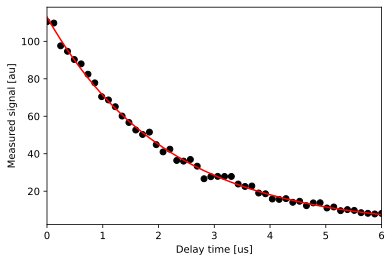

Kappa found is 0.4644930675226834 MHz
5f174a80da77820012e171bb
Job Status: job has successfully run


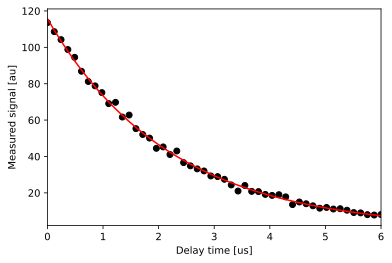

Kappa found is 0.45550418194204484 MHz
5f174c4cda77820012e171c7
Job Status: job has successfully run


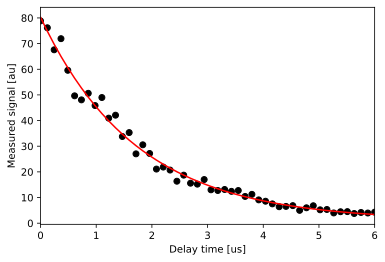

Kappa found is 0.58209523819123 MHz
5f174d5c630c6d001398a413
Job Status: job has successfully run


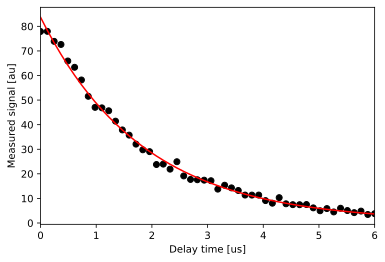

Kappa found is 0.5454609497241012 MHz
5f174f145d734c0013eb208d
Job Status: job has successfully run


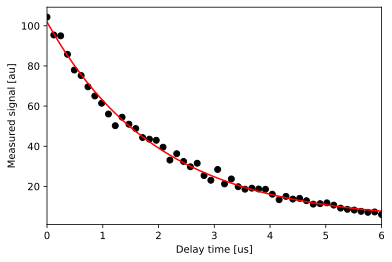

Kappa found is 0.5020034418676461 MHz
5f17514be8256800135003b4
Job Status: job has successfully run


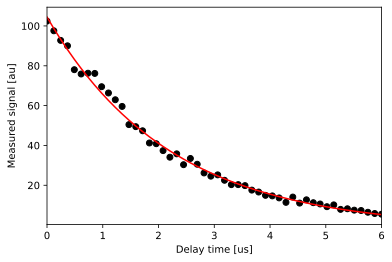

Kappa found is 0.4554757105927033 MHz
5f1752a550d4fa0012c87a0a
Job Status: job has successfully run


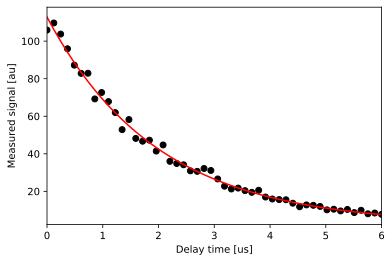

Kappa found is 0.5058566662066185 MHz
5f1753706ab212001867fab5
Job Status: job has successfully run


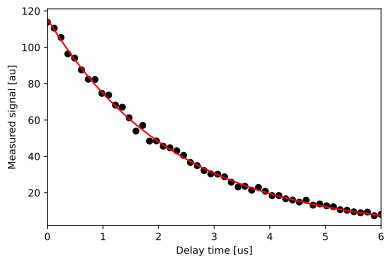

Kappa found is 0.4335828246809531 MHz
5f17543b9324c90012eba55e
Job Status: job has successfully run


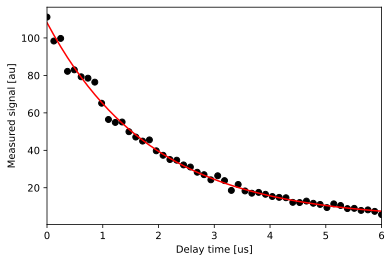

Kappa found is 0.5312045879148365 MHz
5f175505f0eacf001315c092
Job Status: job has successfully run


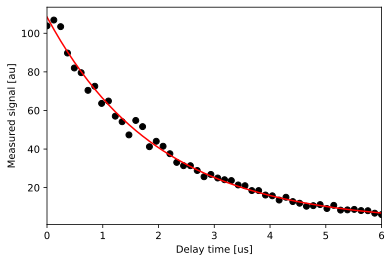

Kappa found is 0.5024833936769247 MHz
5f1755d05d734c0013eb20dd
Job Status: job has successfully run


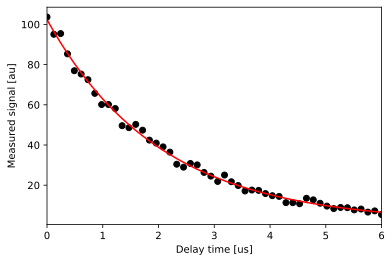

Kappa found is 0.4958623008275973 MHz
5f17569a5d734c0013eb20e6
Job Status: job has successfully run


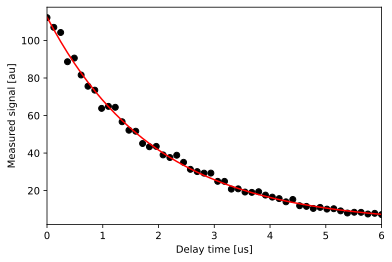

Kappa found is 0.5156511206254298 MHz
5f1757646ab212001867fadc
Job Status: job has successfully run


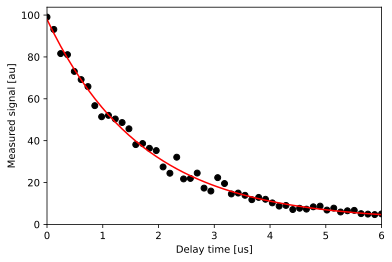

Kappa found is 0.5832799125871334 MHz
5f175831e8256800135003fb
Job Status: job has successfully run


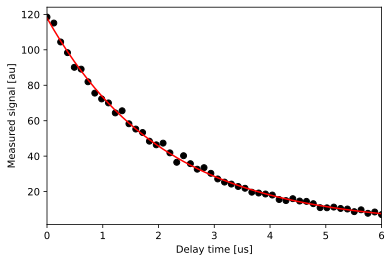

Kappa found is 0.4817898325168182 MHz
5f1758f950d4fa0012c87a4f
Job Status: job has successfully run


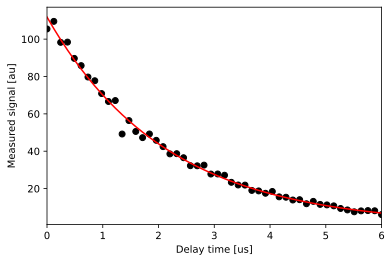

Kappa found is 0.4683352879311938 MHz
5f175a8650d4fa0012c87a69
Job Status: job has successfully run


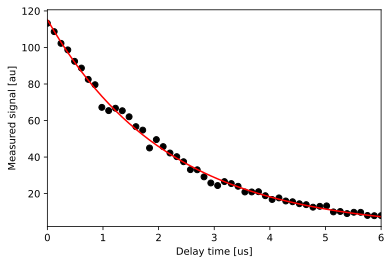

Kappa found is 0.46329346085913 MHz
5f175bde00322900131d70fd
Job Status: job has successfully run


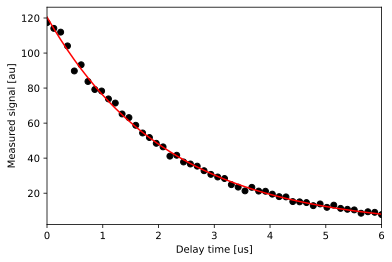

Kappa found is 0.4649066276157717 MHz


In [222]:
num_trials = 20
max_time = 6
kappas_6 = []
for i in range(num_trials):
    kappa = get_kappa(max_time)
    kappas_6.append(kappa)

In [223]:
np.mean(kappas_6)

498163.36617095873

In [232]:
# Save data externally
import json 


kappa_data_decay = {'kappas_real_10us_20': kappas_10, 'kappas_mag_6us_20' : kappas_6}
filehandler = open('kappaDataDecay.txt', 'w')
json.dump(kappa_data_decay, filehandler)
filehandler.close()

5f18a05689c16c00135dc508
Job Status: job has successfully run


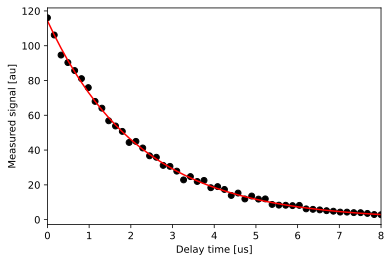

Kappa found is 0.4543067151593399 MHz
5f18a2e79746880012fb39da
Job Status: job has successfully run


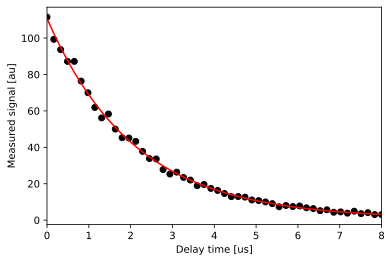

Kappa found is 0.4806448806693131 MHz
5f18a60a89c16c00135dc57a
Job Status: job has successfully run


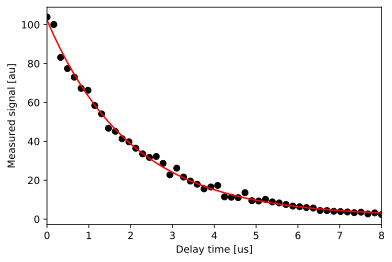

Kappa found is 0.49659223838699734 MHz
5f18a88b755c8b0013e65d59
Job Status: job has successfully run


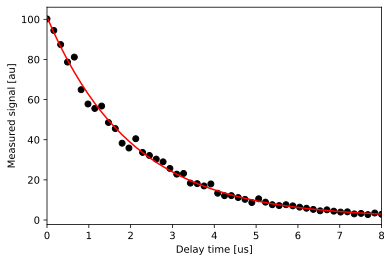

Kappa found is 0.4907200233815374 MHz
5f18a8debe673b0013930203
Job Status: job has successfully run


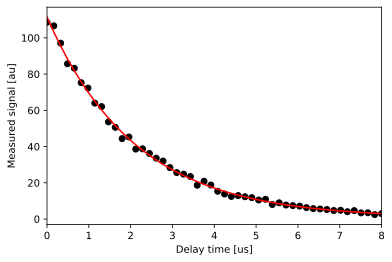

Kappa found is 0.4755549654965292 MHz
5f18ab7389c16c00135dc5de
Job Status: job has successfully run


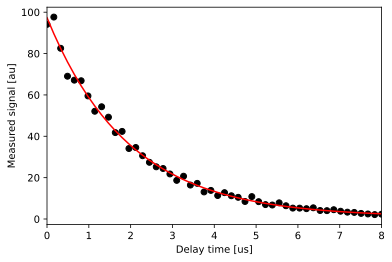

Kappa found is 0.5119909372483117 MHz
5f18adf3da56000015ca3fe7
Job Status: job has successfully run


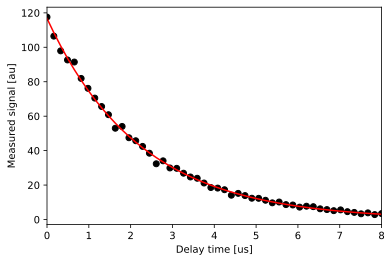

Kappa found is 0.4496615868867474 MHz
5f18ae4526515f0013952667
Job Status: job has successfully run


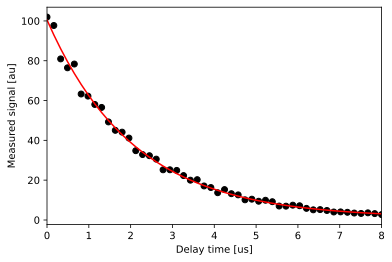

Kappa found is 0.48248326770316063 MHz
5f18b0df89c16c00135dc643
Job Status: job has successfully run


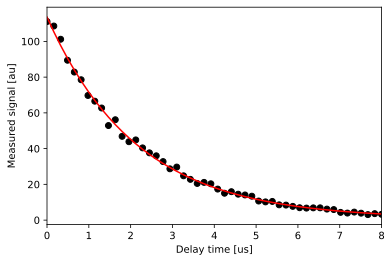

Kappa found is 0.4662209855062337 MHz
5f18b47d646fcb0014e6f4ff
Job Status: job has successfully run


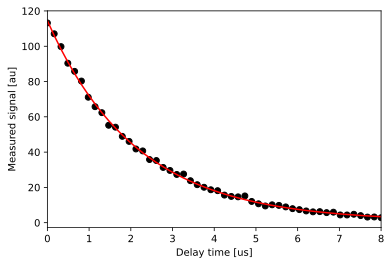

Kappa found is 0.46941247230490457 MHz
5f18b81e5528000014ade4a0
Job Status: job is queued (3)     

KeyboardInterrupt: 

In [234]:
kappas_8 = []
for i in range(num_trials):
    kappa = get_kappa(8)
    kappas_8.append(kappa)

In [244]:
filehandler = open('kappaDataDecay.txt', 'w')
kappa_data_decay = {'kappas_real_10us_20': kappas_10, 'kappas_mag_6us_20' : kappas_6, 'kappas_mag_8_10': kappas_8}
json.dump(kappa_data_decay, filehandler)
filehandler.close()

In [245]:
def job_data_mag(job):
    # extract + normalize results
    job_results = job.result(timeout=120)
    values = []
    for i in range(len(job_results.results)):
        res = job_results.get_memory(i)*scale_factor
        value = np.real(np.sqrt(res[qubit]*np.conjugate(res[qubit])))
        values.append(value)
    return values

def get_kappa_mag(time_max_us):
    # Linewidth experiment parameters
    num_times=50
    times_us = np.linspace(0, time_max_us, num_times, endpoint=True)
    delay_times_dt = times_us * us / dt
    kappa_schedules = [] # separate schedule for each delay time
    for delay in delay_times_dt:
        this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
        this_schedule += Play(cavity_pulse, meas_chan)
        this_schedule += meas_schedule << int(delay)
        kappa_schedules.append(this_schedule)
    
    # assemble schedules
    num_shots = 256
    kappa_experiment = assemble(kappa_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{meas_chan: rough_cavity_freq}] * len(kappa_schedules))

    kappa_job = backend.run(kappa_experiment)
    print(kappa_job.job_id())
    job_monitor(kappa_job)
    
    kappa_data = job_data_mag(kappa_job)
    
    # Fit the data
    kappa_fit_params, kappa_y_fit = fit_function(times_us, kappa_data, 
            lambda x, A, C, k: (A * np.exp(-k*x) + C),
            [3.5, -2, 0.3]
            )
    
    plt.scatter(times_us, kappa_data, color='black')
    plt.plot(times_us, kappa_y_fit, color='red')
    plt.xlim([min(times_us), max(times_us)])
    plt.xlabel("Delay time [us]")
    plt.ylabel("Measured signal [au]")
    plt.show()

    _, _, kappa_MHz = kappa_fit_params
    print(f"Kappa found is {kappa_MHz} MHz")
    
    kappa_Hz = kappa_MHz * MHz
    return kappa_Hz

5f190150646fcb0014e6f8aa
Job Status: job has successfully run


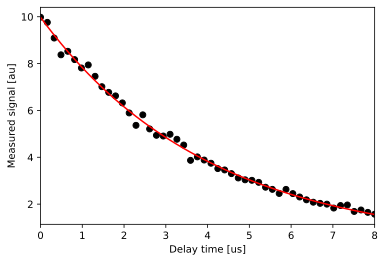

Kappa found is 0.2490972774084351 MHz
5f1907af0ecf67001333f4e0
Job Status: job has successfully run


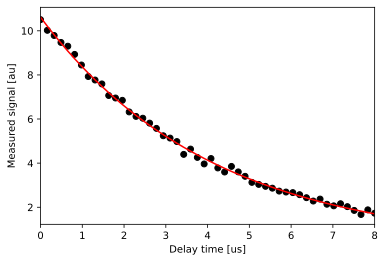

Kappa found is 0.24518017168007744 MHz
5f190fe989c16c00135dcaf6
Job Status: job has successfully run


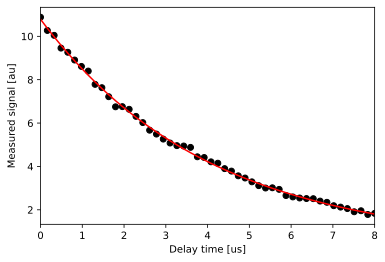

Kappa found is 0.24974949711470518 MHz
5f1919fcae477100126b259d
Job Status: job has successfully run


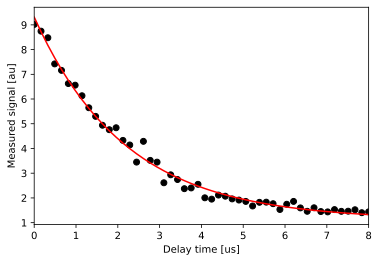

Kappa found is 0.4581677937798153 MHz
5f192034da56000015ca45b1
Job Status: job has successfully run


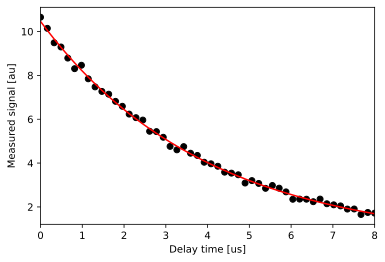

Kappa found is 0.2541550264763996 MHz
5f19214126515f0013952c37
Job Status: job has successfully run


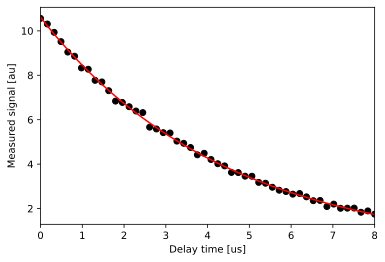

Kappa found is 0.22872068978113336 MHz
5f19299a26515f0013952cb3
Job Status: job has successfully run


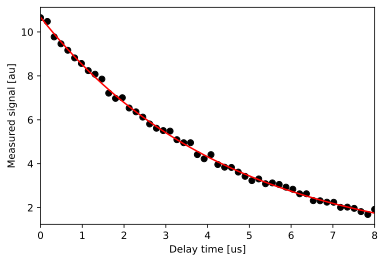

Kappa found is 0.22690655599155585 MHz
5f1931ed9746880012fb4163
Job Status: job has successfully run


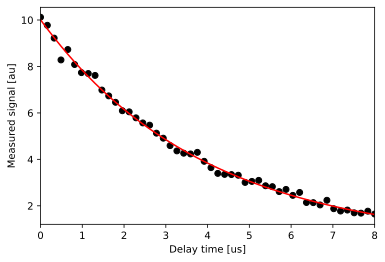

Kappa found is 0.2565206152078232 MHz
5f1938fc646fcb0014e6fb77
Job Status: job has successfully run


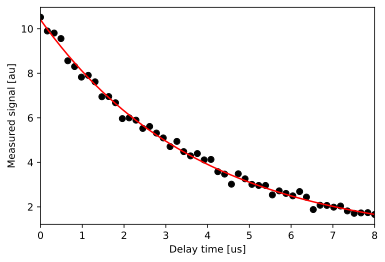

Kappa found is 0.26551008588059505 MHz
5f1940a1be673b00139309c5
Job Status: job has successfully run


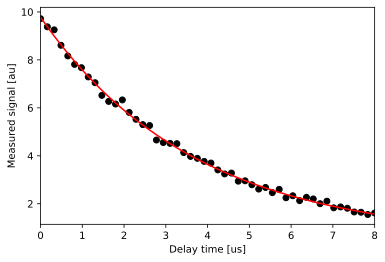

Kappa found is 0.2712516705584326 MHz


In [246]:
kappas_6_mag_sqrt = [] #rename 8
for i in range(10):
    kappa = get_kappa_mag(8)
    kappas_6_mag_sqrt.append(kappa)

In [247]:
def job_data_imag(job):
    # extract + normalize results
    job_results = job.result(timeout=120)
    values = []
    for i in range(len(job_results.results)):
        res = job_results.get_memory(i)*scale_factor
        value = np.imag(res[qubit])
        values.append(value)
    return values

def get_kappa_imag(time_max_us):
    # Linewidth experiment parameters
    num_times=50
    times_us = np.linspace(0, time_max_us, num_times, endpoint=True)
    delay_times_dt = times_us * us / dt
    kappa_schedules = [] # separate schedule for each delay time
    for delay in delay_times_dt:
        this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
        this_schedule += Play(cavity_pulse, meas_chan)
        this_schedule += meas_schedule << int(delay)
        kappa_schedules.append(this_schedule)
    
    # assemble schedules
    num_shots = 256
    kappa_experiment = assemble(kappa_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{meas_chan: rough_cavity_freq}] * len(kappa_schedules))

    kappa_job = backend.run(kappa_experiment)
    print(kappa_job.job_id())
    job_monitor(kappa_job)
    
    kappa_data = job_data_imag(kappa_job)
    
    # Fit the data
    kappa_fit_params, kappa_y_fit = fit_function(times_us, kappa_data, 
            lambda x, A, C, k: (A * np.exp(-k*x) + C),
            [3.5, -2, 0.3]
            )
    
    plt.scatter(times_us, kappa_data, color='black')
    plt.plot(times_us, kappa_y_fit, color='red')
    plt.xlim([min(times_us), max(times_us)])
    plt.xlabel("Delay time [us]")
    plt.ylabel("Measured signal [au]")
    plt.show()

    _, _, kappa_MHz = kappa_fit_params
    print(f"Kappa found is {kappa_MHz} MHz")
    
    kappa_Hz = kappa_MHz * MHz
    return kappa_Hz

In [3]:
import json 
import numpy as np
filehandler = open('kappaDataDecay.txt')
kappa_data = json.load(filehandler)
mag_squared = kappa_data['kappas_mag_squared_8us_10']
np.mean(mag_squared)

477758.8072743075